<a href="https://colab.research.google.com/github/deepak-km-yadav/col_pam/blob/forecasting_assignment/Forecast_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.   Try 4 Models, AutoARIMA, exponentianl Smoothing, SARIMA, SARIMAX and prophet.
2. Create an weighted Ensemble  with best methods.
3. Create a elastic coefficient with CPI Index.
4. Give the forecast. plus relation with CPI
5. Explain economic factors that could be responsible.
6. Why forecasting is Important



In [1]:
# Installing required Libraries
!pip install pmdarima

!pip install prophet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.3 MB/s eta 0:00:00


###### Importing all the libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import io
import os
import sys
import setuptools
import tokenize
import plotly.express as px
from prophet import Prophet  # Uncomment if using Prophet
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

###### Reading and Transforming the Sales data

In [3]:
# Reading athe Sales data
df = pd.read_csv('/content/TB_Raw_Data.csv')
df.head()

,Year,Month,Total ToothBrush Pieces Sold
0,2021,1,105020
1,2021,2,101450
2,2021,3,102355
3,2021,4,101775
4,2021,5,100135


In [4]:
# Creating date from Year and Month Column
df['date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))
df = df.rename(columns={'Total ToothBrush Pieces Sold': 'Sales'})

# Adjust to the last day of the month
df['date'] = df['date'] + pd.offsets.MonthEnd(0)

# Drop the 'year' and 'month' columns
df.drop(['Year', 'Month'], axis=1, inplace=True)

df = df.sort_values(by='date')

max_date = df['date'].max()
min_date = df['date'].min()

print(f"Max Date: {max_date}")
print(f"Min Date: {min_date}")
print(f"\nTotal Datapoints: {len(df)}")



Max Date: 2023-12-31 00:00:00
Min Date: 2021-01-31 00:00:00

Total Datapoints: 36


##### Exploratory Data Analysis

In [5]:

std_dev_sales = df['Sales'].std()

print(f'Standard Deviation of Sales: {std_dev_sales:.2f}')

df['Sales'].describe()

Standard Deviation of Sales: 4044.57


,Sales
count,36.000000
mean,100254.416667
std,4044.567901
min,92490.000000
25%,98105.750000
50%,100053.500000
75%,103257.250000
max,108753.000000


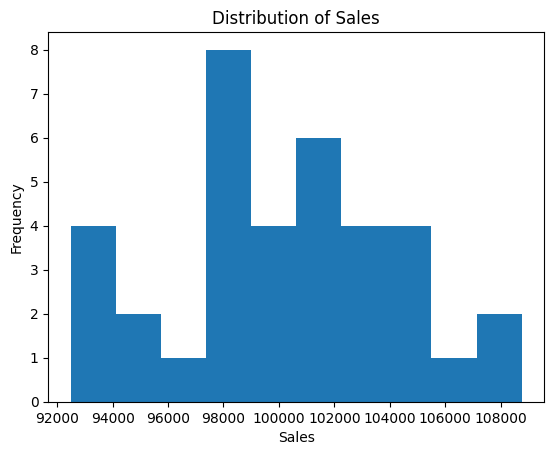

In [6]:
plt.hist(df['Sales'], bins=10)
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

In [7]:
average_sales = df['Sales'].mean()
max_sales = df['Sales'].max()
min_sales = df['Sales'].min()

# Calculate percentage differences from the average
percent_above_average = ((max_sales - average_sales) / average_sales) * 100
percent_below_average = ((average_sales - min_sales) / average_sales) * 100

# Output the results
print(f"Average Sales: {average_sales:.2f}")
print(f"Maximum Sales: {max_sales:.2f}")
print(f"Minimum Sales: {min_sales:.2f}")
print(f"Percentage Higher than Average: {percent_above_average:.2f}%")
print(f"Percentage Lower than Average: {percent_below_average:.2f}%")

Average Sales: 100254.42
Maximum Sales: 108753.00
Minimum Sales: 92490.00
Percentage Higher than Average: 8.48%
Percentage Lower than Average: 7.74%


In [8]:
# Outlier Check
Q1 = df['Sales'].quantile(0.25)
Q3 = df['Sales'].quantile(0.75)

# IQR
IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


outliers = df[(df['Sales'] < lower_bound) | (df['Sales'] > upper_bound)]

print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
print("Outliers:")
print(outliers)

Lower bound: 90378.5, Upper bound: 110984.5
Outliers:
Empty DataFrame
Columns: [Sales, date]
Index: []


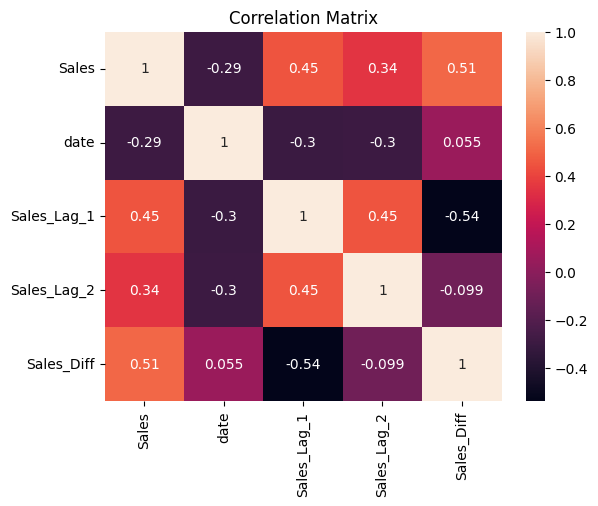

In [9]:
# checking correlation with Sales Lag and differencing

df['Sales_Lag_1'] = df['Sales'].shift(1)
df['Sales_Lag_2'] = df['Sales'].shift(2)

df['Sales_Diff'] = df['Sales'].diff().dropna()

corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix')
plt.show()




In [10]:
df.drop(['Sales_Lag_1',	'Sales_Lag_2',	'Sales_Diff'], inplace=True, axis = 1) # Changed 'Drop' to 'drop'

Diff(1) shows a good correlation with Sales.<br>

**Modeling Consideration:** This information is useful when building forecasting models. For example, in ARIMA modeling, if the first difference is stationary and correlated with the original series, it suggests that an ARIMA model with a differencing component (d=1) might be appropriate.

###### Plotting the interactive time series plot

In [11]:
# Plotting time series plot
fig = px.line(df, x='date', y='Sales', title='Total ToothBrush Pieces Sold Over Time', labels={'Total ToothBrush Pieces Sold': 'Total ToothBrush Pieces Sold', 'date': 'Date'})
fig.update_traces(mode='lines+markers')
fig.update_layout(xaxis_title='Date', yaxis_title='Total ToothBrush Pieces Sold')


fig.show()

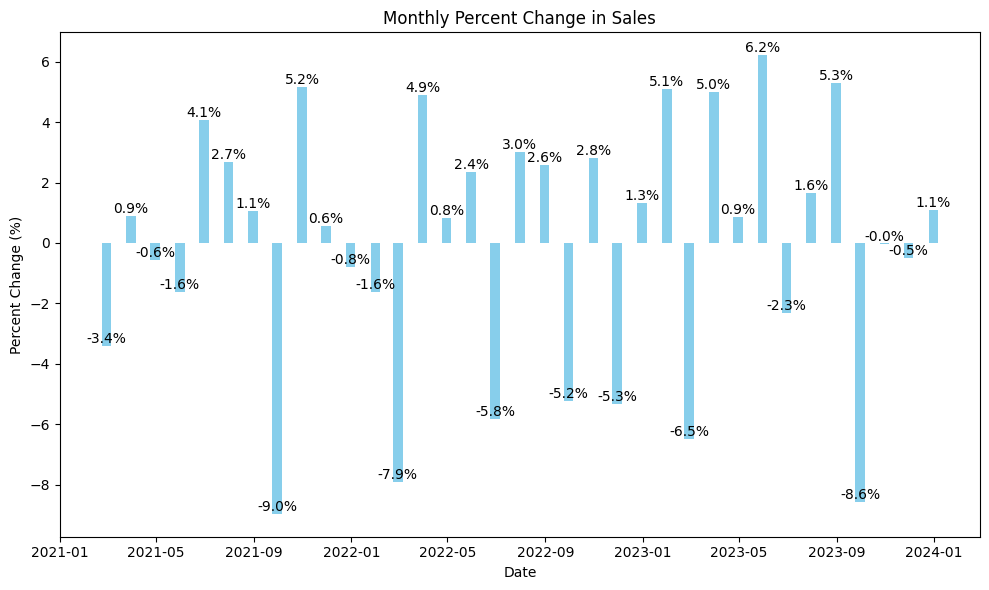

In [35]:
# Calculate the percentage change in sales
df['Percent Change'] = df['Sales'].pct_change() * 100

# Plotting the bar chart with thicker bars and data labels
plt.figure(figsize=(10, 6))
bars = plt.bar(df.index, df['Percent Change'], color='skyblue', width=12)  # Thicker bars
plt.xlabel('Date')
plt.ylabel('Percent Change (%)')
plt.title('Monthly Percent Change in Sales')

# Adding data labels to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.1f}%', va='bottom', ha='center')

plt.tight_layout()
plt.show()

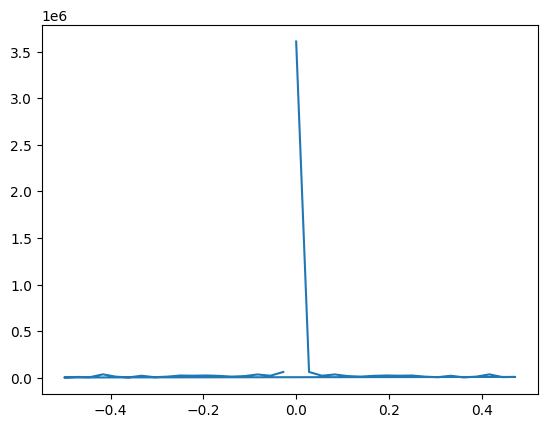

In [13]:
df.drop(['Percent Change'], inplace=True, axis = 1)

# To check Seasonality
# Fast Fourier Transform (FFT)
fft_result = np.fft.fft(df['Sales'])
frequencies = np.fft.fftfreq(len(df['Sales']))

# Plot the amplitude spectrum
plt.plot(frequencies, np.abs(fft_result))
plt.show()

###### Decomposition of the time series

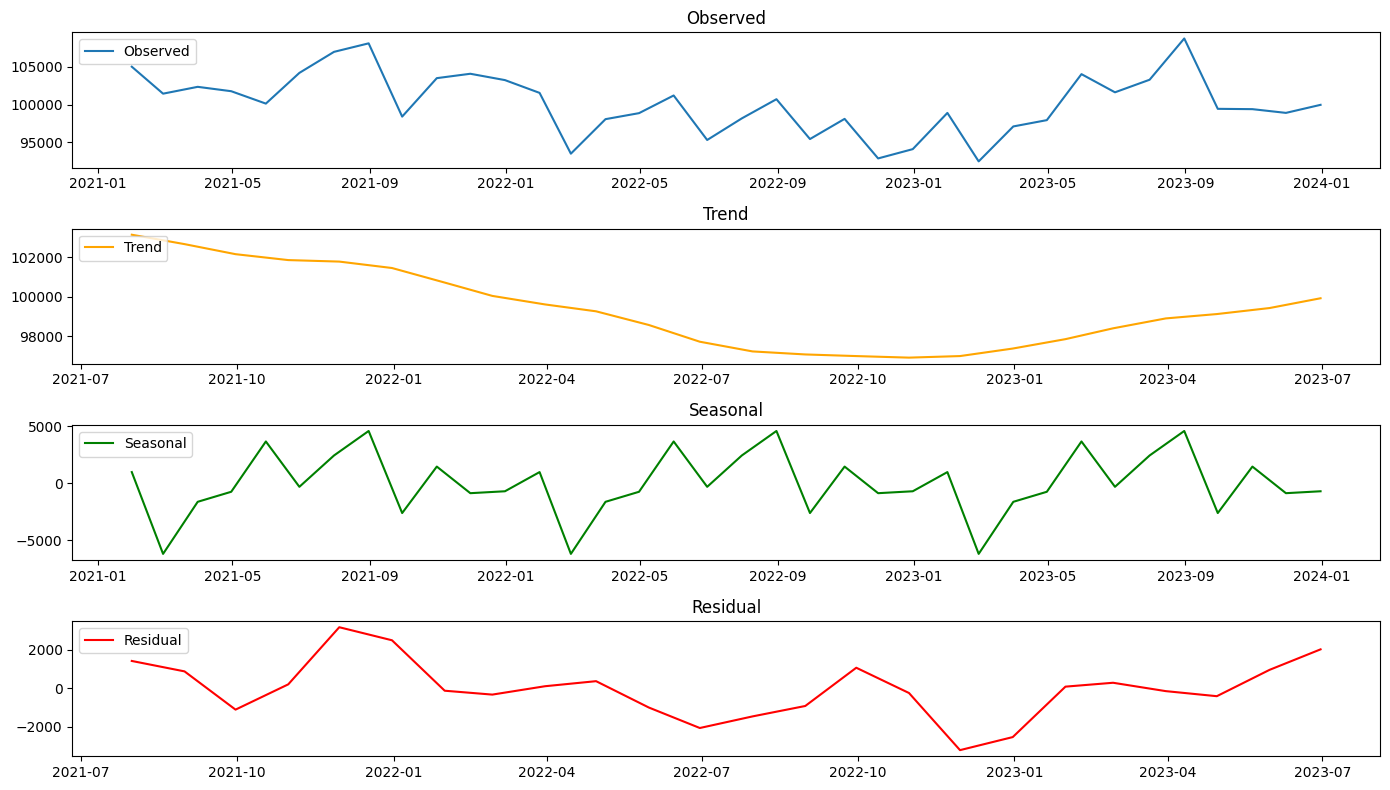

In [14]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Decompose the time series (assuming a monthly frequency)
result = seasonal_decompose(df['Sales'], model='additive', period=12)

# Plotting all the components of the Time series
plt.figure(figsize=(14, 8))

plt.subplot(411)
plt.plot(result.observed, label='Observed')
plt.legend(loc='upper left')
plt.title('Observed')

plt.subplot(412)
plt.plot(result.trend, label='Trend', color='orange')
plt.legend(loc='upper left')
plt.title('Trend')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.title('Seasonal')

plt.subplot(414)
plt.plot(result.resid, label='Residual', color='red')
plt.legend(loc='upper left')
plt.title('Residual')

plt.tight_layout()
plt.show()


###### ACF and PACF


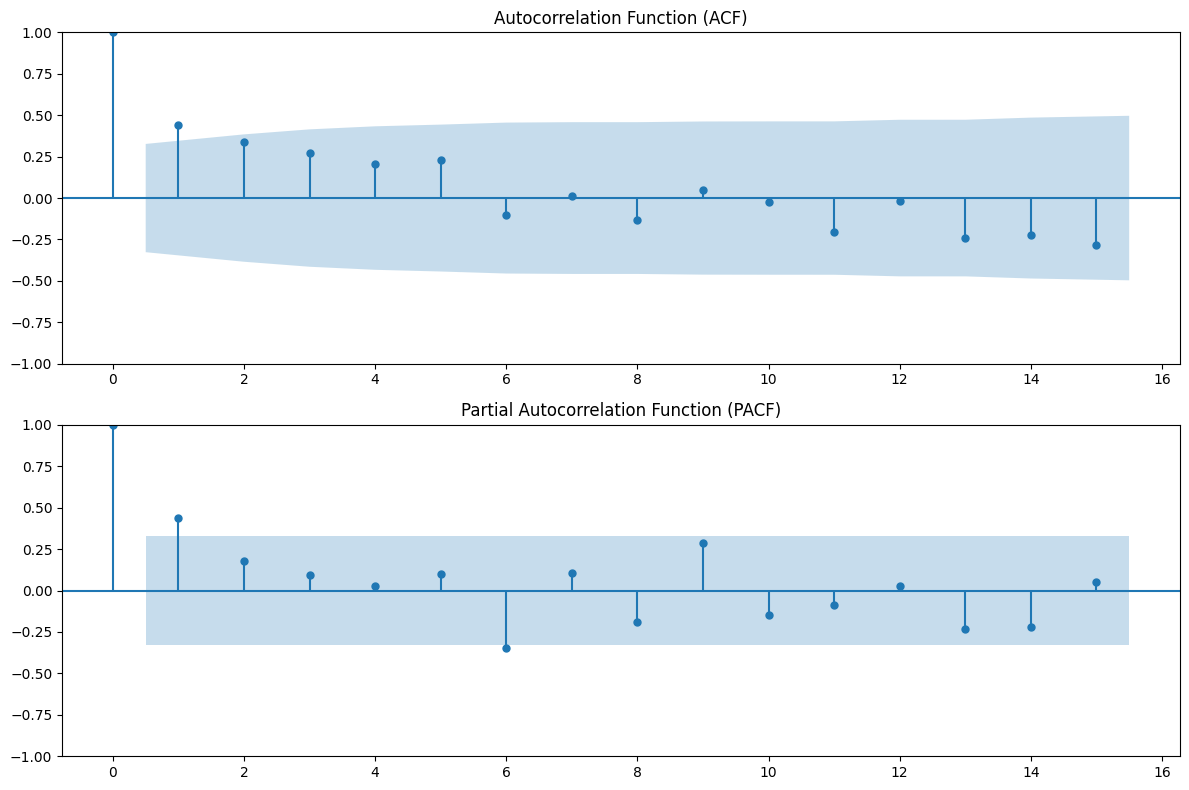

In [15]:
# Plot ACF and PACF
fig, ax = plt.subplots(2, figsize=(12, 8))

# ACF plot
plot_acf(df['Sales'], ax=ax[0], lags=15)
ax[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(df['Sales'], ax=ax[1], lags=15)
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

**AR Component**: The significant spike at lag 1 in the PACF suggests that an AR(1) model might be appropriate. The ACF also supports this with a gradually decreasing pattern, typical of an AR model.<br>
**MA Component:** The lack of significant lags in the ACF plot, other than the first few, suggests that an MA component may not be strong.

###### Running  Augmented Dickey-Fuller

Running  Augmented Dickey-Fuller (ADF) test to check if Timeseries is stationary or not.<br>
**Hypotheses:**<br>

**Null Hypothesis (H0)**: The time series has a unit root, meaning it is non-stationary.<br>
**Alternative Hypothesis (H1)**: The time series is stationary.

In [16]:
result = adfuller(df['Sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

for key, value in result[4].items():
    print(f'Critical Value {key}: {value}')

# Conclusion based on p-value
if result[1] < 0.05:
    print("\n The time series is stationary (reject H0)")
else:
    print("\n The time series is non-stationary (fail to reject H0)")

ADF Statistic: -3.6824926468368036
p-value: 0.004366259577150215
Critical Values: {'1%': -3.6327426647230316, '5%': -2.9485102040816327, '10%': -2.6130173469387756}
Critical Value 1%: -3.6327426647230316
Critical Value 5%: -2.9485102040816327
Critical Value 10%: -2.6130173469387756

 The time series is stationary (reject H0)


###### Running SARIMA, AutoARIMA, ETS, Prophet Timeseries Models

In [17]:
import time
from IPython.display import clear_output

# Example loop to demonstrate clearing output
for i in range(5):
    print(f'Iteration {i}')
    time.sleep(1)  # Wait for 1 second
    clear_output(wait=True)  # Clear output and wait for next output

print('Final Output')


# Set the frequency to monthly
df = df.asfreq('M')

# Split the data into train and test sets
train = df.iloc[:-6]  # first 30 months
test = df.iloc[-6:]   # last 6 months

# Function to calculate RMSE and MAPE
def calculate_metrics(true_values, predictions):
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    mape = mean_absolute_percentage_error(true_values, predictions) * 100
    return rmse, mape


order = (1, 1, 0) # For ARIMA

# Fit ARIMA model
arima_model = ARIMA(train['Sales'], order=order)
arima_fitted = arima_model.fit()
forecast_periods = 6
arima_forecast = arima_fitted.forecast(steps=forecast_periods)

# Calculate evaluation metrics
arima_rmse, arima_mape = calculate_metrics(test['Sales'], arima_forecast)


# Auto ARIMA
auto_arima_model = auto_arima(train['Sales'], seasonal=False, stepwise=True)
auto_arima_forecast = auto_arima_model.predict(n_periods=6)
auto_arima_rmse, auto_arima_mape = calculate_metrics(test['Sales'], auto_arima_forecast)

# SARIMA
sarima_model = SARIMAX(train['Sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_model_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_model_fit.forecast(steps=6)
sarima_rmse, sarima_mape = calculate_metrics(test['Sales'], sarima_forecast)

# ETS (Exponential Smoothing)
ets_model = ExponentialSmoothing(train['Sales'], trend='add', seasonal='add', seasonal_periods=12)
ets_model_fit = ets_model.fit()
ets_forecast = ets_model_fit.forecast(steps=6)
ets_rmse, ets_mape = calculate_metrics(test['Sales'], ets_forecast)

# Prophet
prophet_df = train.reset_index().rename(columns={'date': 'ds', 'Sales': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=6, freq='M')
forecast = prophet_model.predict(future)
prophet_forecast = forecast.iloc[-6:]['yhat'].values
prophet_rmse, prophet_mape = calculate_metrics(test['Sales'], prophet_forecast)


clear_output()
# Print results
print(f'ARIMA RMSE:    {arima_rmse:.2f}, MAPE: {arima_mape:.2f}%')
print(f'Auto ARIMA RMSE: {auto_arima_rmse:.2f}, MAPE: {auto_arima_mape:.2f}%')
print(f'SARIMA RMSE:     {sarima_rmse:.2f}, MAPE: {sarima_mape:.2f}%')
print(f'ETS RMSE:        {ets_rmse:.2f}, MAPE: {ets_mape:.2f}%')
print(f'Prophet RMSE:    {prophet_rmse:.2f}, MAPE: {prophet_mape:.2f}%')

ARIMA RMSE:    3500.00, MAPE: 2.88%
Auto ARIMA RMSE: 3498.12, MAPE: 2.84%
SARIMA RMSE:     2324.31, MAPE: 1.88%
ETS RMSE:        3640.28, MAPE: 3.02%
Prophet RMSE:    8140.71, MAPE: 6.85%


The analysis shows that the SARIMA model outperforms the other
models (Auto ARIMA, ETS, and Prophet) in terms of both RMSE and MAPE. Therefore, for this particular dataset, SARIMA is the most accurate and reliable model for forecasting.<br>

The Auto ARIMA model also performs well, making it a good alternative.

###### Creating Ensemble forecast using best 2 models

In [18]:
# this code calculates the wights to be assigned for the models based on thier mape
# Mape Values from the Model
mape_values = {
    'auto_arima': auto_arima_mape,
    'sarima': sarima_mape,
    'ets': ets_mape,
    'prophet': prophet_mape
}

# Sort the models based on MAPE values in ascending order
sorted_models = sorted(mape_values, key=mape_values.get)

# Select the top 2 models with the lowest MAPE
top_models = sorted_models[:2]

# Get MAPE values for only the top 2 models
top_mape = [mape_values[model] for model in top_models]

# Calculate the inverse of MAPE to use as weights
inverse_mape = [1/mape for mape in top_mape]

# Normalize the weights so that they sum to 1
weights = [w / sum(inverse_mape) for w in inverse_mape]

# Create a dictionary to map models to their respective forecasts
forecasts = {
    'auto_arima': auto_arima_forecast,
    'sarima': sarima_forecast,
    'ets': ets_forecast,
    'prophet': prophet_forecast
}

# Get the forecasts for the top 2 models
top_forecasts = [forecasts[model] for model in top_models]

# Calculate the weighted ensemble forecast
ensemble_forecast = sum(weight * forecast for weight, forecast in zip(weights, top_forecasts))


print("Top 2 models:", top_models)
print("Weights:", weights)
#print("Ensemble Forecast:", ensemble_forecast)

ensemble_rmse, ensemble_mape = calculate_metrics(test['Sales'], ensemble_forecast)

# Print results
print(f'\nAuto ARIMA RMSE: {auto_arima_rmse:.2f}, MAPE: {auto_arima_mape:.2f}%')
print(f'SARIMA RMSE:     {sarima_rmse:.2f}, MAPE: {sarima_mape:.2f}%')
print(f'ETS RMSE:        {ets_rmse:.2f}, MAPE: {ets_mape:.2f}%')
print(f'Prophet RMSE:    {prophet_rmse:.2f}, MAPE: {prophet_mape:.2f}%')
print(f'Ensemble RMSE:   {ensemble_rmse:.2f}, MAPE: {ensemble_mape:.2f}%')


Top 2 models: ['sarima', 'auto_arima']
Weights: [0.6012546949458799, 0.3987453050541201]

Auto ARIMA RMSE: 3498.12, MAPE: 2.84%
SARIMA RMSE:     2324.31, MAPE: 1.88%
ETS RMSE:        3640.28, MAPE: 3.02%
Prophet RMSE:    8140.71, MAPE: 6.85%
Ensemble RMSE:   2555.18, MAPE: 2.05%


###### Tuning the best order i.e. *SARIMA*

In [19]:
# This code does a grid search for best order paramerets for SARIMA using AIC value

y = df['Sales']

# Define the p, d, q ranges for non-seasonal and seasonal components
p = d = q = range(0, 3)
seasonal_p = seasonal_d = seasonal_q = range(0, 2)
seasonal_period = 12  # e.g., monthly data with yearly seasonality

# Generate all combinations of p, d, q, P, D, Q
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(seasonal_p, seasonal_d, seasonal_q))

best_aic = float("inf")
best_order = None
best_seasonal_order = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(y, order=param, seasonal_order=seasonal_param + (seasonal_period,))
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = seasonal_param
        except:
            continue

print(f'Best SARIMA{best_order}x{best_seasonal_order + (seasonal_period,)} - AIC:{best_aic}')


Best SARIMA(2, 1, 2)x(0, 1, 1, 12) - AIC:440.14658466335504


In [20]:
# Extract the p, d, q parameters from auto_arima_model
p = auto_arima_model.order[0]
d = auto_arima_model.order[1]
q = auto_arima_model.order[2]

print(f'Optimal parameters: p={p}, d={d}, q={q}')

Optimal parameters: p=0, d=1, q=0


In [21]:
#Best SARIMA(2, 1, 2)x(0, 1, 1, 12) - AIC:440.14658466335504
#Use order from ARIMA

# SARIMA
sarima_model = SARIMAX(train['Sales'], order=(p, d, q), seasonal_order=(0, 1, 1, 12))
sarima_model_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_model_fit.forecast(steps=6)
sarima_rmse, sarima_mape = calculate_metrics(test['Sales'], sarima_forecast)

print(f'SARIMA RMSE: {sarima_rmse:.2f}, MAPE: {sarima_mape:.2f}%')





SARIMA RMSE: 2279.29, MAPE: 1.74%


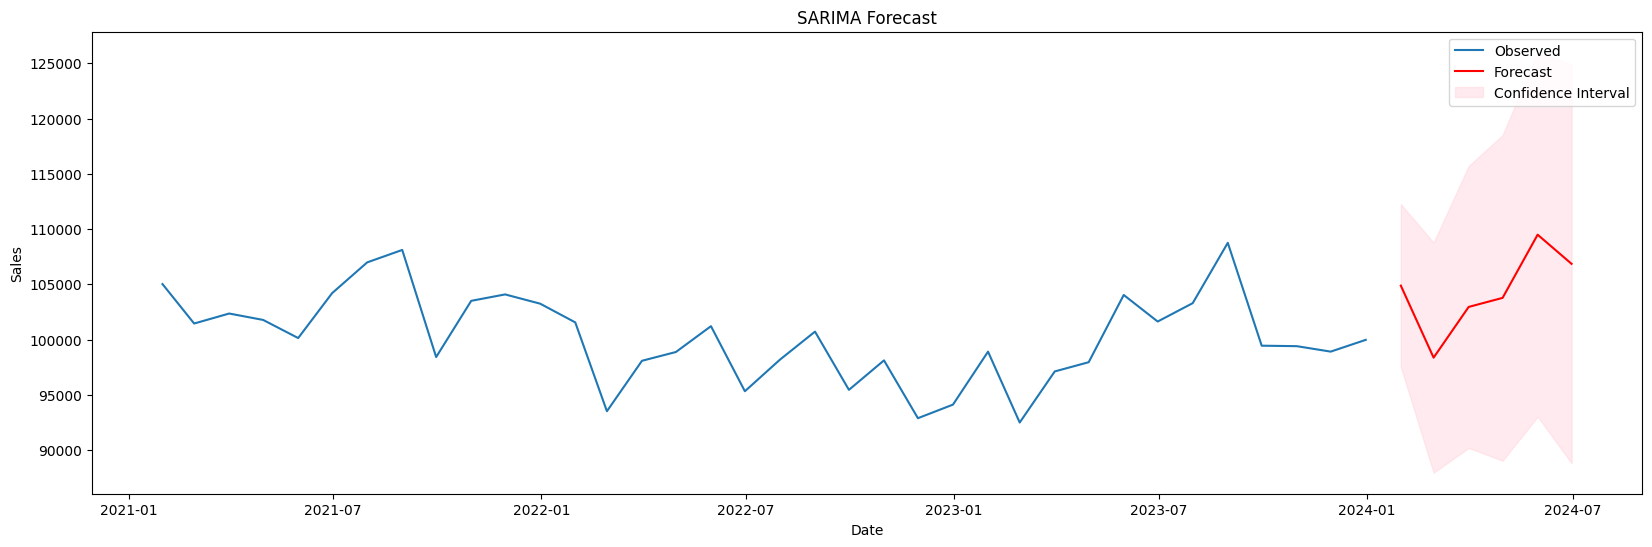

In [22]:
# Train SARIMA on full data and forecast for next 6 Months
full_model = SARIMAX(df['Sales'], order=(p, d, q), seasonal_order=(0, 1, 1, 12))
full_model_fit = full_model.fit(disp=False)
sarima_forecast = sarima_model_fit.forecast(steps=6)

# Forecast for the next 4 periods (e.g., months if monthly data)
forecast_steps = 6
sarima_forecast = full_model_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq='M')[1:]

# Extract the forecasted mean and confidence intervals
forecast_mean = sarima_forecast.predicted_mean
forecast_conf_int = sarima_forecast.conf_int()

# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(df['Sales'], label='Observed')
plt.plot(forecast_index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()


In [23]:
# Plotly chart for Interactive visual
import plotly.graph_objects as go

# Sample data (replace with your actual data)
observed_dates = df.index
observed_sales = df['Sales']
forecast_dates = forecast_index
forecast_values = forecast_mean
conf_int_lower = forecast_conf_int.iloc[:, 0]
conf_int_upper = forecast_conf_int.iloc[:, 1]

# Create traces
observed_trace = go.Scatter(
    x=observed_dates,
    y=observed_sales,
    mode='lines',
    name='Observed'
)

forecast_trace = go.Scatter(
    x=forecast_dates,
    y=forecast_values,
    mode='lines+text',
    name='Forecast',
    line=dict(color='red'),
    text=forecast_values,
    textposition='top center',
    texttemplate='%{text:.2f}'
)

conf_int_trace = go.Scatter(
    x=forecast_dates.tolist() + forecast_dates[::-1].tolist(),
    y=conf_int_upper.tolist() + conf_int_lower[::-1].tolist(),
    fill='toself',
    fillcolor='rgba(255, 192, 203, 0.3)',
    line=dict(color='rgba(255,255,255,0)'),
    showlegend=True,
    name='Confidence Interval'
)

# Combine all traces
fig = go.Figure(data=[observed_trace, forecast_trace, conf_int_trace])

# Add titles and labels
fig.update_layout(
    title='SARIMA Forecast',
    xaxis_title='Date',
    yaxis_title='Sales'
)

# Show the figure
fig.show()


##### Forecast for next three Months

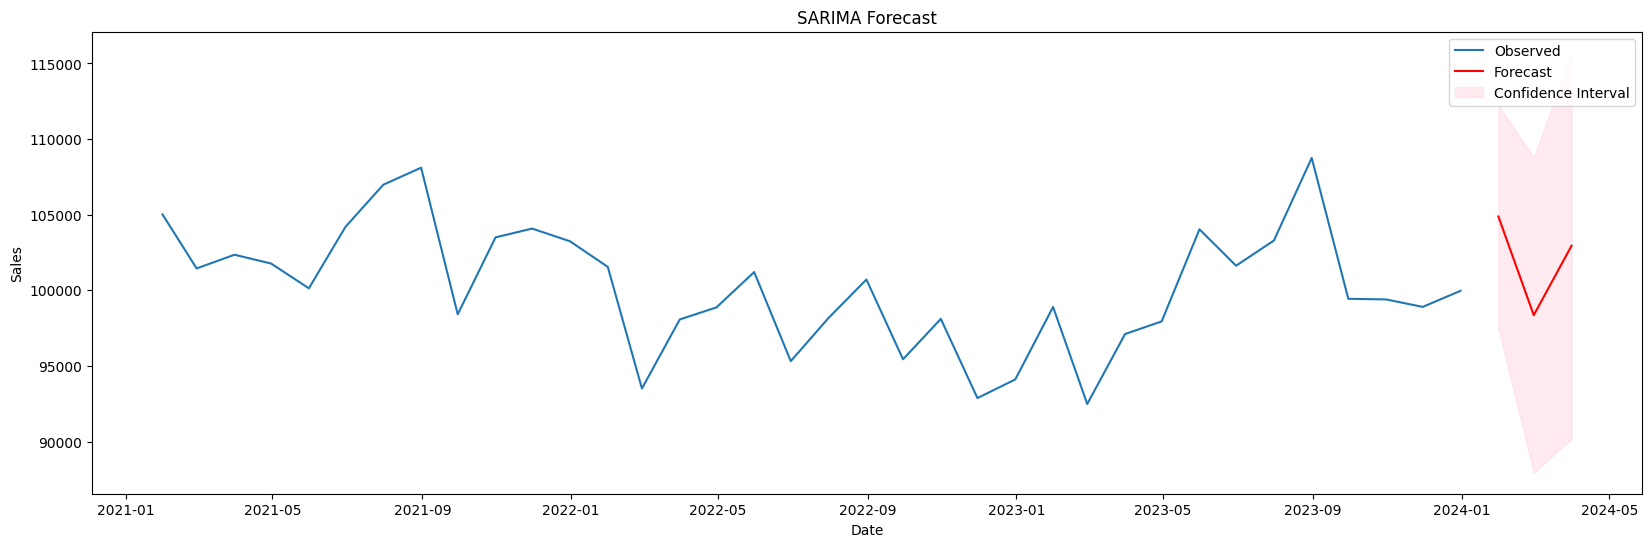

In [24]:
full_model_fit = full_model.fit(disp=False)
sarima_forecast = sarima_model_fit.forecast(steps=6)

# Forecast for the next 3 months.
forecast_steps = 3
sarima_forecast = full_model_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq='M')[1:]

# Extract the forecasted mean and confidence intervals
forecast_mean = sarima_forecast.predicted_mean
forecast_conf_int = sarima_forecast.conf_int()

# Plot the results
plt.figure(figsize=(20, 6))
plt.plot(df['Sales'], label='Observed')
plt.plot(forecast_index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_index,
                 forecast_conf_int.iloc[:, 0],
                 forecast_conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

In [25]:
#https://economictimes.indiatimes.com/industry/cons-products/fmcg/big-scope-to-grow-toothpaste-market-colgate-palmolive-india-md-prabha-narasimhan/articleshow/110157056.cms?from=mdr


### Additional Analysis of sales with monthly CPI Data

The **Consumer Price Index (CPI)** is a measure that examines the weighted average of prices of a basket of consumer goods and services, such as transportation, food, and medical care. It is used to assess changes in the cost of living and to measure inflation.

In [26]:
# Read CPI data (data extracted from Investing.com)

cpi_data = pd.read_csv('/content/Economic_Data_Final.csv')

cpi_data['Release Date'] = cpi_data['Release Date'].str.split(' \\(').str[0]

cpi_data ['Release Date'] = pd.to_datetime(cpi_data ['Release Date']).dt.strftime('%Y-%m-%d')

cpi_data['Release Date'] = pd.to_datetime(cpi_data['Release Date'])

cpi_data['Release Date'] = cpi_data['Release Date'] + pd.offsets.MonthEnd(0)

cpi_data.head()

,Release Date,Time,Actual,Forecast,Previous
0,2024-07-31,17:30,5.08%,4.80%,4.80%
1,2024-06-30,17:30,4.75%,4.90%,4.83%
2,2024-05-31,17:30,4.83%,4.80%,4.85%
3,2024-04-30,17:30,4.85%,4.91%,5.09%
4,2024-03-31,17:30,5.09%,5.02%,5.10%


In [27]:

# Rename the 'Release Date' column in cpi_data to 'date' for the join
cpi_data = cpi_data.rename(columns={'Release Date': 'date'})
cpi_data.set_index('date', inplace=True)


merged_df = df.join(cpi_data, how='inner')
merged_df.drop(['Time'], inplace=True, axis = 1)

# Remove '%' sign and convert to integers for 'Actual' and 'Forecast' columns
merged_df['Actual'] = merged_df['Actual'].str.rstrip('%').astype(float)
merged_df['Forecast'] = merged_df['Forecast'].str.rstrip('%').astype(float)
merged_df['Previous'] = merged_df['Previous'].str.rstrip('%').astype(float)

merged_df.head()


,Sales,Actual,Forecast,Previous
date,,,,
2021-01-31,105020,4.59,5.28,6.93
2021-02-28,101450,4.06,4.45,4.59
2021-03-31,102355,5.03,4.83,4.06
2021-04-30,101775,5.52,5.40,5.03
2021-05-31,100135,4.29,4.20,5.52


In [28]:
# Plotting the interactive time series plot
fig = px.line(merged_df, x=merged_df.index, y='Previous', title='CPI Index overtime', labels={'CPI Index': 'CPI Index', 'date': 'Date'})
fig.update_traces(mode='lines+markers')
fig.update_layout(xaxis_title='Date', yaxis_title='CPI Index')

# Show the plot
fig.show()

In [29]:
from plotly.subplots import make_subplots
# Create subplots with two y-axes
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(
    go.Scatter(x=merged_df.index, y=merged_df['Sales'], name='Sales'),
    secondary_y=False,
)


fig.add_trace(
    go.Scatter(x=merged_df.index, y=merged_df['Previous'], name='Previous', line=dict(dash='dash')),
    secondary_y=True,
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="Sales", secondary_y=False)
fig.update_yaxes(title_text="CPI Index", secondary_y=True)

# Update layout
fig.update_layout(
    title_text="Sales and CPI Index Over Time",
    legend=dict(x=0, y=1.2)
)


fig.show()

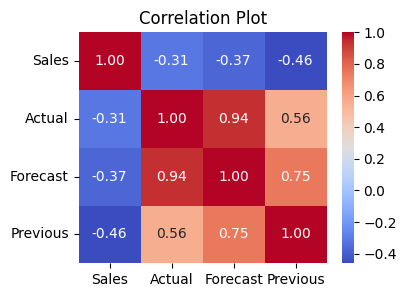

In [30]:

# Calculate the correlation matrix
correlation_matrix = merged_df[['Sales', 'Actual', 'Forecast', 'Previous']].corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(4, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Plot')
plt.show()




*  There is a good negative correlation between Previous Months CPI Index on the Sales (-0.46)
*   CPI Index could be a good indicator.



In [31]:


# Define dependent and independent variables
X = np.log(merged_df['Previous'])
y = np.log(merged_df['Sales'])

# Add a constant to the independent variables matrix (to include an intercept in the model)
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit the model on the training data
model = sm.OLS(y_train, X_train).fit()

# Predict on the test data
y_pred = model.predict(X_test)

# Calculate performance metrics
r_squared = model.rsquared
adjusted_r_squared = model.rsquared_adj
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

# Print the performance metrics
print(f'R-squared: {r_squared:.2f}')
print(f'Adjusted R-squared: {adjusted_r_squared:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')

# Retrain the model on the entire dataset
full_model = sm.OLS(y, X).fit()

# Print the model summary
print(full_model.summary())


R-squared: 0.08
Adjusted R-squared: 0.05
RMSE: 0.04
MAPE: 0.25%
                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     9.553
Date:                Thu, 01 Aug 2024   Prob (F-statistic):            0.00397
Time:                        17:09:58   Log-Likelihood:                 69.414
No. Observations:                  36   AIC:                            -134.8
Df Residuals:                      34   BIC:                            -131.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

In [32]:


# Assuming merged_df is your DataFrame with 'Sales' and 'Previous' columns

# Define the independent and dependent variables
X = np.log(merged_df[['Previous']]).values  # Independent variable
y = np.log(merged_df['Sales']).values       # Dependent variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create the linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Calculate performance metrics
r_squared = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

# Calculate adjusted R-squared
n = len(y_test)  # number of observations
p = X_test.shape[1]  # number of predictors
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

# Print the performance metrics
print(f'R-squared: {r_squared:.2f}')
print(f'Adjusted R-squared: {adjusted_r_squared:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')


# Print the model coefficients
print(f'Intercept: {model.intercept_}')
print(f'Coefficient: {model.coef_[0]}')


R-squared: 0.41
Adjusted R-squared: 0.31
RMSE: 0.04
MAPE: 0.25%
Intercept: 11.625585918492984
Coefficient: -0.06395492129540416


In [33]:


# Save the DataFrame to a CSV file
merged_df.to_csv('/content/merged_data.csv', index=True)  # Set index=True to include the index in the CSV
